In this tutorial we'll make adversarial examples for MNIST dataset using tensorflow and Keras<br>
**REQUIREMENTS**<br>
1. install all the libraries included in requirements.txt
2. install he adversarial-robustness-toolbox as shown here https://github.com/IBM/adversarial-robustness-toolbox
3. Go to /usr/local/lib/python3.5/dist-packages/config and paste the config.ini file from the config folder here

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from os.path import abspath
import sys
sys.path.append(abspath('.'))

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import tensorflow as tf

from art.attacks.deepfool import DeepFool
from art.attacks.fast_gradient import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset
from art.classifiers import KerasClassifier, TFClassifier
from art.utils import load_mnist
import keras
from matplotlib import pyplot as plt

Using TensorFlow backend.


We'll first make a small neural network for classifying our MNIST Dataset, 

In [2]:
def cnn_mnist_tf(input_shape):
    labels_tf = tf.placeholder(tf.float32, [None, 10])
    inputs_tf = tf.placeholder(tf.float32, [None] + list(input_shape))

    # Define the tensorflow graph
    conv = tf.layers.conv2d(inputs_tf, 4, 5, activation=tf.nn.relu)
    conv = tf.layers.max_pooling2d(conv, 2, 2)
    fc = tf.contrib.layers.flatten(conv)

    # Logits layer
    logits = tf.layers.dense(fc, 10)

    # Train operator
    loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=labels_tf))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_tf = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    classifier = TFClassifier((0, 1), inputs_tf, logits, loss=loss, train=train_tf, output_ph=labels_tf, sess=sess)
    return classifier

In [3]:
def cnn_mnist_k(input_shape):
    # Create simple CNN
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=['accuracy'])

    classifier = KerasClassifier((0, 1), model, use_logits=False)
    return classifier

In [4]:
# Get session
session = tf.Session()
k.set_session(session)

# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Construct and train a convolutional neural network on MNIST using Keras
source = cnn_mnist_k(x_train.shape[1:])
source.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Epoch 1/5
469/468 [==============================] - 15s 32ms/step - loss: 0.2033 - acc: 0.9397
Epoch 2/5
469/468 [==============================] - 12s 26ms/step - loss: 0.0879 - acc: 0.9736
Epoch 3/5
469/468 [==============================] - 12s 26ms/step - loss: 0.0682 - acc: 0.9792
Epoch 4/5
469/468 [==============================] - 15s 32ms/step - loss: 0.0608 - acc: 0.9814
Epoch 5/5
469/468 [==============================] - 17s 35ms/step - loss: 0.0524 - acc: 0.9832


In [5]:
# Craft adversarial samples with DeepFool
adv_crafter = DeepFool(source)
x_train_adv = adv_crafter.generate(x_train)
x_test_adv = adv_crafter.generate(x_test)

In [6]:
# Construct and train a convolutional neural network
target = cnn_mnist_tf(x_train.shape[1:])
target.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
# Evaluate the CNN on the adversarial samples
preds = target.predict(x_test_adv)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nAccuracy on adversarial samples: %.2f%%" % (acc * 100))


Accuracy on adversarial samples: 0.00%


/home/prabhant/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
preds = source.predict(x_test_adv)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("\nAccuracy on adversarial samples: %.2f%%" % (acc * 100))


Accuracy on adversarial samples: 0.00%


/home/prabhant/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


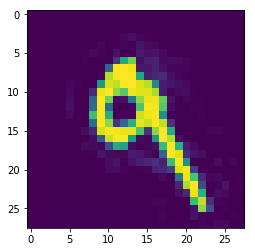

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

In [9]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()
    return plt
gen_image(x_test_adv[7])